# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [ ]:
import random
import numpy as np
import pickle
# from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
import os
from random import randrange

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y


def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1, 6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [ ]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/content'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]

    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image

    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [ ]:
from builtins import range
import numpy as np
from random import shuffle


def softmax_loss_naive(W, X, y, reg):
    """
    Softmax loss function, naive implementation (with loops)

    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.

    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N = X.shape[0] # num samples

    for i in range(N):
        y_hat = X[i] @ W                    # raw scores vector
        y_exp = np.exp(y_hat - y_hat.max()) # numerically stable exponent vector
        softmax = y_exp / y_exp.sum()       # pure softmax for each score
        loss -= np.log(softmax[y[i]])       # append cross-entropy
        softmax[y[i]] -= 1                  # update for gradient
        dW += np.outer(X[i], softmax)       # gradient

    loss = loss / N + reg * np.sum(W**2)    # average loss and regularize
    dW = dW / N + 2 * reg * W               # finish calculating gradient

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.

    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N = X.shape[0] # number of samples
    Y_hat = X @ W  # raw scores matrix

    P = np.exp(Y_hat - Y_hat.max())      # numerically stable exponents
    P /= P.sum(axis=1, keepdims=True)    # row-wise probabilities (softmax)

    loss = -np.log(P[range(N), y]).sum() # sum cross entropies as loss
    loss = loss / N + reg * np.sum(W**2) # average loss and regularize

    P[range(N), y] -= 1                  # update P for gradient
    dW = X.T @ P / N + 2 * reg * W       # calculate gradient

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW

In [ ]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

# from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.309684
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**


There are `10` classes which means that, on average, there is `0.1` probability of each class.



In [ ]:
def grad_check_sparse(f, x, analytic_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in this dimensions.
    """

    for i in range(num_checks):
        ix = tuple([randrange(m) for m in x.shape])

        oldval = x[ix]
        x[ix] = oldval + h  # increment by h
        fxph = f(x)  # evaluate f(x + h)
        x[ix] = oldval - h  # increment by h
        fxmh = f(x)  # evaluate f(x - h)
        x[ix] = oldval  # reset

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = abs(grad_numerical - grad_analytic) / \
            (abs(grad_numerical) + abs(grad_analytic))
        print('numerical: %f analytic: %f, relative error: %e' %
              (grad_numerical, grad_analytic, rel_error))

In [ ]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
# from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -6.139983 analytic: -6.139983, relative error: 5.835335e-09
numerical: 1.319704 analytic: 1.319704, relative error: 2.248410e-08
numerical: 1.094911 analytic: 1.094911, relative error: 3.277763e-08
numerical: -1.306996 analytic: -1.306996, relative error: 1.642942e-10
numerical: 2.101198 analytic: 2.101198, relative error: 9.669453e-09
numerical: -1.816871 analytic: -1.816871, relative error: 2.906618e-08
numerical: 0.144621 analytic: 0.144621, relative error: 5.849691e-08
numerical: 1.255460 analytic: 1.255460, relative error: 2.328783e-08
numerical: 0.925346 analytic: 0.925346, relative error: 2.082118e-08
numerical: -1.068099 analytic: -1.068099, relative error: 9.985276e-09
numerical: -2.198312 analytic: -2.198312, relative error: 8.153188e-09
numerical: -1.196480 analytic: -1.196480, relative error: 4.322021e-09
numerical: -0.490404 analytic: -0.490404, relative error: 4.001378e-08
numerical: -3.058996 analytic: -3.058996, relative error: 9.146020e-09
numerical: -0.0606

In [ ]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

# from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.309684e+00 computed in 0.107657s
vectorized loss: 2.309684e+00 computed in 0.012544s
Loss difference: 0.000000
Gradient difference: 0.000000


In [ ]:
import numpy as np
# from cs231n.classifiers.linear_svm import *
# from cs231n.classifiers.softmax import *


class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        # assume y takes values 0...K-1 where K is number of classes
        num_classes = np.max(y) + 1
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            batch_indices = np.random.choice(
                num_train, batch_size, replace=True)
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            self.W -= learning_rate * grad


            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: D x N array of training data. Each column is a D-dimensional point.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[1])
        scores = X.dot(self.W)
        y_pred = np.argmax(scores, axis=1)
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.

        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.

        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        pass


class Softmax(LinearClassifier):
    """ A subclass that uses the Softmax + Cross-entropy loss function """

    def loss(self, X_batch, y_batch, reg):
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)

In [ ]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

# from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = np.linspace(1e-7, 1e-6, 5)
regularization_strengths = np.linspace(1e3, 1e4, 5)

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create Softmax and train it
    softmax = Softmax()
    softmax.train(X_train, y_train, lr, reg, num_iters=1000)

    # Compute training and validation sets accuracies and append to the dictionary
    y_train_pred, y_val_pred = softmax.predict(X_train), softmax.predict(X_val)
    results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)

    # Save if validation accuracy is the best
    if results[(lr, reg)][1] > best_val:
        best_val = results[(lr, reg)][1]
        best_softmax = softmax

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.246347 val accuracy: 0.242000
lr 1.000000e-07 reg 3.250000e+03 train accuracy: 0.273000 val accuracy: 0.256000
lr 1.000000e-07 reg 5.500000e+03 train accuracy: 0.294653 val accuracy: 0.300000
lr 1.000000e-07 reg 7.750000e+03 train accuracy: 0.317041 val accuracy: 0.340000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.333102 val accuracy: 0.331000
lr 3.250000e-07 reg 1.000000e+03 train accuracy: 0.325122 val accuracy: 0.321000
lr 3.250000e-07 reg 3.250000e+03 train accuracy: 0.374429 val accuracy: 0.384000
lr 3.250000e-07 reg 5.500000e+03 train accuracy: 0.370061 val accuracy: 0.376000
lr 3.250000e-07 reg 7.750000e+03 train accuracy: 0.356673 val accuracy: 0.374000
lr 3.250000e-07 reg 1.000000e+04 train accuracy: 0.358510 val accuracy: 0.367000
lr 5.500000e-07 reg 1.000000e+03 train accuracy: 0.368694 val accuracy: 0.368000
lr 5.500000e-07 reg 3.250000e+03 train accuracy: 0.382735 val accuracy: 0.398000
lr 5.500000e-07 reg 5.500000

In [ ]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.381000


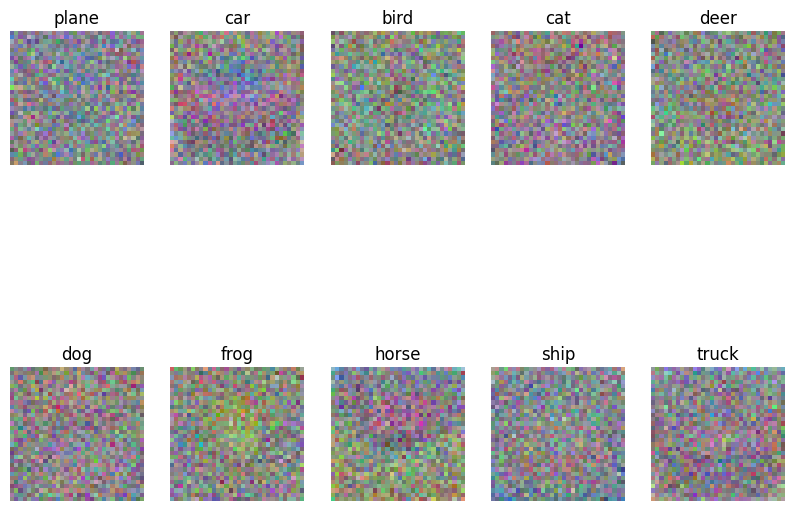

In [ ]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])